## Baro Array

### Importing

In [7]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import obspy
import pandas as pd

from obspy.clients.fdsn import Client, RoutingClient
from obspy.signal.array_analysis import array_transff_wavenumber
from obspy.imaging.cm import obspy_sequential
from obspy.geodetics import locations2degrees

from andbro__querrySeismoData import __querrySeismoData



### Setting Variables

In [25]:
config = {}

config['klim'] = 50.
config['kstep'] = config['klim'] / 100.

config['tbeg'] = obspy.UTCDateTime("2019-05-14 12:17")
config['tend'] = obspy.UTCDateTime("2019-05-14 14:00")


config['seeds'] = [
                   'BW.GELB..HH*',
                   'BW.GRMB..HH*',
                   'BW.ALFT..HH*',
                   'BW.BIB..HH*',
                   'BW.TON..HH*',
                   # 'BW.FFB1..HH*',
                   # 'BW.FFB2..HH*',
                   # 'BW.FFB3..HH*',
                   'BW.DROMY..HH*',
                   # 'GR.FUR..HH*',
]

config['ref_station'] = 'BW.DROMY..HH*'

config['client'] = RoutingClient("eida-routing")

### Defining Methods

In [110]:
def __get_array_stations(seed_id, tbeg, tend, ref_station=None, max_radius=0.1):

    net0, sta0, loc0, cha0  = ref_station.split(".")

    inv_ref = config['client'].get_stations(
                                            network = net0,
                                            station = sta0,
                                            channel = cha0,
                                            starttime = tbeg,
                                            endtime = tend,
                                            )

    ref_coords = [inv_ref[0][0].latitude, inv_ref[0][0].longitude, inv_ref[0][0].elevation]


    net, sta, loc, cha  = seed_id.split(".")

    route =  RoutingClient("eida-routing")

    inv_check =route.get_stations(
                                    network=net,
                                    station=sta,
                                    channel=cha,
                                    starttime=tbeg,
                                    endtime=tend,
                                    latitude=ref_coords[0],
                                    longitude=ref_coords[1],
                                    minradius=0,
                                    maxradius=max_radius,
                                )

    # inv_check.plot(projection="local");

    codes, lon, lat, elev = [], [], [], []
    for h, network in enumerate(inv_check):
        for i, station in enumerate(network):

            codes.append(f'{inv_check[h].code}.{station.code}')
            lon.append(station.longitude)
            lat.append(station.latitude)
            elev.append(station.elevation/1000.)

    # create dataframe
    frame = pd.DataFrame({'codes': codes, 'lon': lon, 'lat': lat, 'elev': elev})

    # sort the dataframe
    frame.sort_values(by="codes", inplace=True)

    return frame

In [111]:
array_stations = __get_array_stations("BW.*.*.*", config['tbeg'], config['tend'], ref_station=config['ref_station'])


In [112]:
array_stations

,codes,lon,lat,elev
2,BW.ALFT,11.279500,48.142334,0.593
6,BW.BIB,11.247300,48.152200,0.599
8,BW.DROMY,11.275476,48.162941,0.571
7,BW.FFB1,11.275065,48.162904,0.572
0,BW.FFB2,11.273684,48.164357,0.577
9,BW.FFB3,11.276289,48.164883,0.562
3,BW.GELB,11.251400,48.162900,0.628
4,BW.GRMB,11.263500,48.140600,0.656
5,BW.ROMY,11.275476,48.162941,0.571
1,BW.TON,11.288809,48.173897,0.564


In [121]:
def __array_latlon_to_xyz(array_stations, ref_station="GR.FUR"):
    """Convert angluar to cartesian coordiantes

    latitude is the 90deg - zenith angle in range [-90;90]
    lonitude is the azimuthal angle in range [-180;180] 
    """

    from numpy import zeros
    import utm

    # modify ref_station
    net, sta, loc, cha = ref_station.split(".")
    ref_station = f"{net}.{sta}"

    if ref_station not in list(array_stations.codes):
        print(f"-> {ref_station} not vaild")
        return


    for _i in ["x_m", "y_m", "z_m", "utm_zone", "utm_letter"]:
        array_stations[_i] = zeros(array_stations.shape[0])

    sta_ref = array_stations[array_stations.codes == ref_station]
    utm_ref_e, utm_ref_n, utm_zone, utm_letter = utm.from_latlon(sta_ref.lat.iloc[0], sta_ref.lon.iloc[0])
    z_ref = sta_ref.elev.iloc[0]

    for i, sta in array_stations.iterrows():

        utm_e, utm_n, utm_zone, utm_letter = utm.from_latlon(sta.lat, sta.lon)

        array_stations.loc[i, "x_m"] = round(( utm_e - utm_ref_e ), 2)
        array_stations.loc[i, "y_m"] = round(( utm_n - utm_ref_n ), 2)
        array_stations.loc[i, "z_m"] = ( array_stations.loc[i, "elev"] - z_ref ) * 1e3
        array_stations.loc[i, "utm_zone"] = utm_zone
        array_stations.loc[i, "utm_letter"] = str(utm_letter)

    return array_stations

In [122]:
array_stations = __array_latlon_to_xyz(array_stations, ref_station=config['ref_station'])

In [123]:
array_stations

,codes,lon,lat,elev,x_m,y_m,z_m,utm_zone,utm_letter
2,BW.ALFT,11.279500,48.142334,0.593,367.11,-2281.38,22.0,32.0,U
6,BW.BIB,11.247300,48.152200,0.599,-2060.10,-1255.39,28.0,32.0,U
8,BW.DROMY,11.275476,48.162941,0.571,0.00,0.00,0.0,32.0,U
7,BW.FFB1,11.275065,48.162904,0.572,-30.44,-5.02,1.0,32.0,U
0,BW.FFB2,11.273684,48.164357,0.577,-137.90,153.43,6.0,32.0,U
9,BW.FFB3,11.276289,48.164883,0.562,54.06,217.62,-9.0,32.0,U
3,BW.GELB,11.251400,48.162900,0.628,-1790.01,-57.27,57.0,32.0,U
4,BW.GRMB,11.263500,48.140600,0.656,-817.36,-2509.26,85.0,32.0,U
5,BW.ROMY,11.275476,48.162941,0.571,0.00,0.00,0.0,32.0,U
1,BW.TON,11.288809,48.173897,0.564,955.10,1247.08,-7.0,32.0,U


In [146]:
def __calculate_distance_of_stations(array_stations, output="km", ref_station=None):
    '''
    from obspy.geodetics import locations2degrees

    '''

    from numpy import round

    N = len(array_stations)

    # modify ref_station
    net, sta, loc, cha = ref_station.split(".")
    ref_station = f"{net}.{sta}"

    if ref_station is not None:
        dist_in_deg = {}
        station1 = array_stations[array_stations.codes == ref_station]
        lat1, lon1 = station1.lat, station1.lon
        for j, station2 in array_stations.iterrows():
            name = str(station2.codes)
            _dist= locations2degrees(lat1  = lat1,
                                      long1 = lon1,
                                      lat2  = station2[2],
                                      long2 = station2[1],
                                      )
            if output == "km":
                dist_in_deg[name] = round(_dist[0]*111, decimals=2)
            elif output == "deg":
                dist_in_deg[name] = round(_dist[0], decimals=2)

    else:
        dist_in_deg = np.zeros((N, N))
        for i, station1 in array_stations.iterrows():
            for j, station2 in array_stations.iterrows():
                 _dist = locations2degrees(lat1  = station1[2],
                                          long1 = station1[1],
                                          lat2  = station2[2],
                                          long2 = station2[1],
                                          )
            if output == "km":
                dist_in_deg[i][j] = round(_dist*111, decimals=2)
            elif output == "deg":
                dist_in_deg[i][j] = round(_dist, decimals=2)

    return dist_in_deg

## Compute station distance

In [164]:
distances = __calculate_distance_of_stations(array_stations, output="km", ref_station=config['ref_station'])
distances

{'BW.ALFT': 2.31,
 'BW.BIB': 2.4,
 'BW.DROMY': 0.0,
 'BW.FFB1': 0.03,
 'BW.FFB2': 0.21,
 'BW.FFB3': 0.22,
 'BW.GELB': 1.78,
 'BW.GRMB': 2.63,
 'BW.ROMY': 0.0,
 'BW.TON': 1.57}

### Calulcate Distances, Plot Array Geometry and Response

In [179]:
def __plotArrayGeometryAndResponse(array, transff, klim, kstep, names=None, unit=None):

    import numpy as np

    # calulcate geometrical center of array
    array_center = [np.median(array[:,0]), np.median(array[:,1])]

    # find geometrical limits of array
    lon_min, lon_max = np.min(array[:,0]), np.max(array[:,0])
    lat_min, lat_max = np.min(array[:,1]), np.max(array[:,1])

    # define bounds
    kxmin, kxmax, kymin, kymax = -klim, klim, -klim, klim


    # _________________________________________________________
    #
    fig, axes = plt.subplots(1,2, figsize=(16,6))

    fs=12

    if unit == "km":
        xdata = (array[:, 0]-array_center[0])*111.
        ydata = (array[:, 1]-array_center[1])*111. * np.cos(array[:,1]/180.*np.pi)
        x0, y0 = array_center[0]*111., array_center[1]*111. * np.cos(array[1]/180.*np.pi)

    elif unit == "deg":
        xdata = array[:, 0]
        ydata = array[:, 1]
        x0, y0 = array_center[0], array_center[1]

    # ________________________________________________
    axes[0].scatter(xdata, ydata, s=35, color='black', marker='v', zorder=3)
    axes[0].scatter(x0, y0, color='red', marker='o', s=25, zorder=2)

    if unit == "km" or unit is None:
        axes[0].set_xlabel('X (km)', fontsize=fs)
        axes[0].set_ylabel('Y (km)', fontsize=fs)

        axes[0].set_ylim([-max(abs(ydata))*1.2, max(abs(ydata))*1.2])
        axes[0].set_xlim([-max(abs(xdata))*1.2, max(abs(xdata))*1.2])

    elif unit == "deg":
        axes[0].set_xlabel('Longitude (°)', fontsize=fs)
        axes[0].set_ylabel('Latitude (°)', fontsize=fs)

        axes[0].set_ylim([min(abs(ydata))+0.1, max(abs(ydata))+0.1])
        axes[0].set_xlim([min(abs(xdata))+0.1, max(abs(xdata))+0.1])

    axes[0].set_title('Square Array configuration', fontsize=fs+2)

    for x, y, s in zip(xdata, ydata, list(names)):
        axes[0].text(x, y, s, ha="right", va="top")

    # ________________________________________________
    ax2 = axes[1].pcolor(np.arange(kxmin, kxmax + kstep * 1.1, kstep) - kstep / 2.,
                         np.arange(kymin, kymax + kstep * 1.1, kstep) - kstep / 2.,
                         transff.T, cmap=obspy_sequential,
                        )

    plt.colorbar(ax2, ax=axes[:])
    ax2.set_clim(0., 1.)

    axes[1].set_xlim(kxmin, kxmax)
    axes[1].set_ylim(kymin, kymax)
    axes[1].set_xlabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_ylabel('wave number (m$^{-1}$)', fontsize=fs)
    axes[1].set_title('ARF Square Array', fontsize=fs+2)

    plt.show();


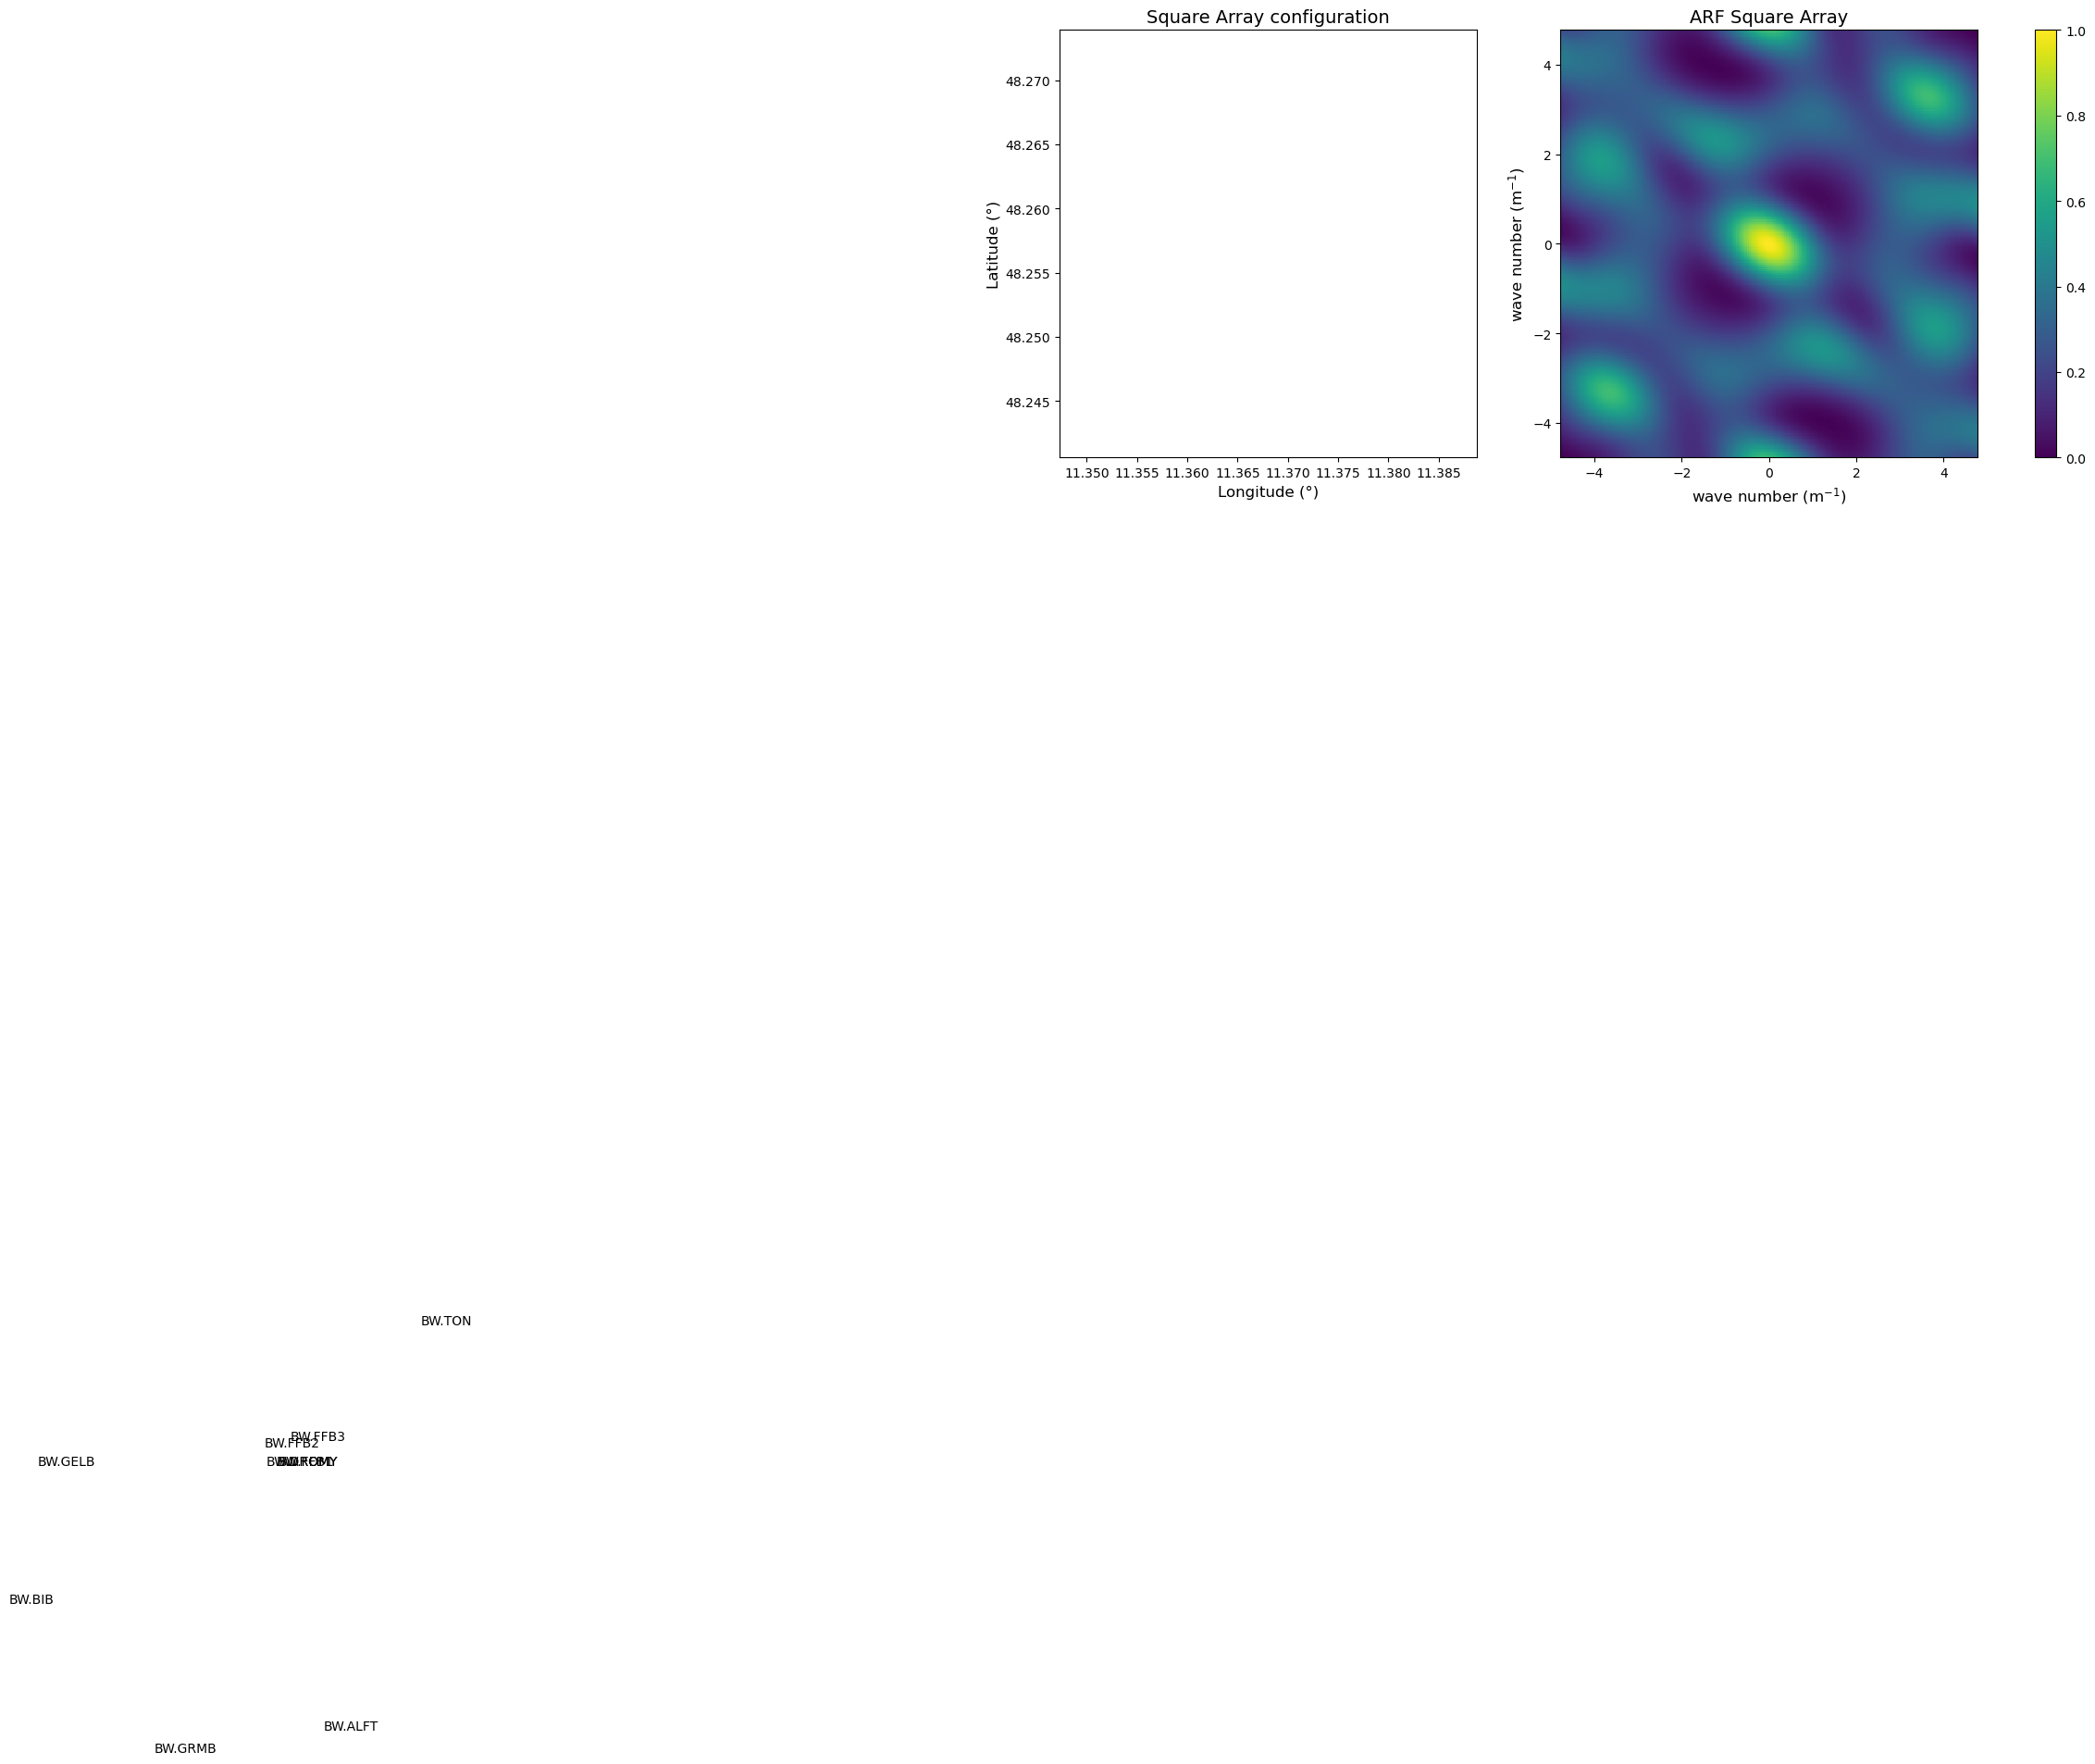

In [180]:
# get maximal distance
dist_max = max(distances.values())

lambda_min = .5*dist_max # in km

config['k_max'] = 2*np.pi/lambda_min
config['k_step'] = config['k_max'] / 100.

coordinates = np.column_stack([array_stations.lon, array_stations.lat, array_stations.elev])

## compute transfer function as a function of wavenumber difference
transff = array_transff_wavenumber(coordinates,
                                   config['k_max'],
                                   config['k_step'],
                                   coordsys='lonlat'
                                   )


__plotArrayGeometryAndResponse(coordinates,
                               transff,
                               config['k_max'],
                               config['k_step'],
                               array_stations.codes,
                               unit="deg",
                              )

In [163]:
import pygmt

def __getMapParameters(lats, lons):

    # Determine a nice, padded region
    region = [np.min(lons), np.max(lons), np.min(lats), np.max(lats)]
    x_pad = (region[1] - region[0]) * 0.3
    y_pad = (region[3] - region[2]) * 0.3
    region = [region[0] - x_pad, region[1] + x_pad, region[2] - y_pad, region[3] + y_pad]

    # Determine a nice stereographic projection
    lon_0 = np.mean(region[:2])
    lat_0 = np.mean(region[2:])
    ref_lat = 90 if lat_0 > 0 else -90
    projection = f'S{lon_0}/{ref_lat}/6i'

    return region, projection

region, projection = __getMapParameters(array_stations.lat, array_stations.lon)

fig = pygmt.Figure()


fig.coast(
        region=region,
        projection=projection,
        shorelines=True,
        water='lightblue',
        rivers=[1],
        land='lightgrey',
        borders=[1, 2],
        frame='a',
)

KWARGS = dict(
              grid='@srtm_relief_01s',
              region=region,
              projection=projection,
              frame=False,
              shading=True,
              cmap='earth',
             )
fig.grdimage(**KWARGS)


fig.plot(array_stations.lon, array_stations.lat, style='i0.2i', color='white', pen=True)

fig.text(x=array_stations.lon, 
         y=array_stations.lat, 
         text=[code.split(".")[1] for code in array_stations.codes],
         offset=[0.2, 0.5],
         font="12p,Helvetica-Bold,white"
        )

fig.colorbar()


fig.show()

/tmp/ipykernel_332868/886045871.py:46: FutureWarning: The 'color' parameter has been deprecated since v0.8.0 and will be removed in v0.12.0. Please use 'fill' instead.
  fig.plot(array_stations.lon, array_stations.lat, style='i0.2i', color='white', pen=True)


GMTInvalidInput: Too much data. Use either data or x and y.

In [ ]:
import xarray as xr

axis = np.arange(-config['klim'], config['klim']+0.5,0.5)
print( len(axis))

model = xr.DataArray(transff.T, coords=(axis, axis), dims=('lat', 'lon'))


fig = pygmt.Figure()


fig.coast(
        region=region,
        projection=projection,
        shorelines=True,
        water='lightblue',
        rivers=[1],
        land='lightgrey',
        borders=[1, 2],
        frame='a',
)

KWARGS = dict(
              grid=transff.T,
              region=region,
              projection=projection,
              frame=False,
              shading=True,
              cmap='earth',
             )
fig.grdimage(**KWARGS)


fig.plot(array_stations.lon, array_stations.lat, style='i0.2i', color='white', pen=True)

fig.text(x=array_stations.lon, 
         y=array_stations.lat, 
         text=[code.split(".")[1] for code in array_stations.codes],
         offset=[0.2, 0.5],
         font="12p,Helvetica-Bold,white"
        )

fig.colorbar()


fig.show()

In [ ]:
transff.T.shape